# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
import pandas as pd
import numpy as np
from pylab import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn import model_selection, preprocessing, ensemble, metrics, manifold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from random import sample
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\nspap\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure(figsize=(15,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("ROC-AUC score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")
    print('Точка максимального качества на кросс-валидации:', max(list(zip(test_scores_mean, train_sizes))))
    return plt

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [12]:
train_data = pd.read_csv('orange_small_churn_train_data.csv')
test_data = pd.read_csv('orange_small_churn_test_data.csv')
train_data.drop([18298], axis=0, inplace=True)

In [13]:
numeric_train = train_data.iloc[:, 1:191].fillna(0)
numeric_test = test_data.iloc[:, 1:191].fillna(0)
categorial_train = train_data.iloc[:, 191:-2]
categorial_test = test_data.iloc[:, 191:-1]
y = train_data.iloc[:, 231]

In [14]:
categorial = pd.concat([categorial_train, categorial_test], axis=0)
categorial_encode = categorial.fillna('?').apply(LabelEncoder().fit_transform)
categorial_train_encode = categorial_encode.iloc[:18298, :]
categorial_test_encode = categorial_encode.iloc[18298:, :]
X_train = pd.concat([numeric_train, categorial_train_encode], axis=1)
X_test = pd.concat([numeric_test, categorial_test_encode], axis=1)

In [15]:
xgb_class = xgb.XGBClassifier(booster='gbtree', learning_rate=0.2, max_depth=1, n_estimators=100)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 17)

Точка максимального качества на кросс-валидации: (0.7284939366991734, 16468)


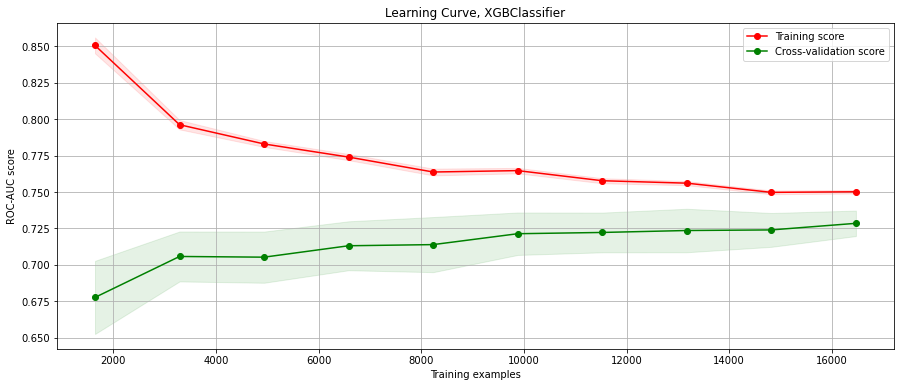

In [16]:
plot_learning_curve(xgb_class, 'Learning Curve, XGBClassifier', X_train, y, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.show()

Как видим, качество модели на кросс-валидации растет в зависимости от количества объектов в обучении, переобучения не происходит, лучше использовать весь датасет.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Зададим 3 коэффициента взвешивания - 1 к 1, корень квадратный отношения объектов с меткой 1 к объектам с меткой -1 и просто отношение объектов.

In [17]:
weights = [1, sqrt(y.value_counts()[1] / y.value_counts()[-1]), y.value_counts()[1] / y.value_counts()[-1], 0.03]
weights

[1, 0.2852685912240248, 0.08137816913893978, 0.03]

ROC-AUC при различных весах:

In [18]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 17)
for w in weights:    
    xgb_class = xgb.XGBClassifier(
        booster='gbtree', learning_rate=0.2, max_depth=1, n_estimators=100, scale_pos_weight=w)
    w_cv_scores = cross_val_score(xgb_class, X_train, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f'weights = {w:.2f}, ROC-AUC = {w_cv_scores.mean():.4}')

weights = 1.00, ROC-AUC = 0.7285
weights = 0.29, ROC-AUC = 0.7277
weights = 0.08, ROC-AUC = 0.728
weights = 0.03, ROC-AUC = 0.7267


Лучший результат при весах 1 к 1, но близкий у него при 0.08, можно будет попробовать оба эти варианта.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

ROC-AUC при обучении на всей выборке

In [19]:
cv_scores0 = cross_val_score(xgb_class, X_train, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores0.mean())

ROC-AUC 0.7266762342647708


Первый вариант - одинаковое количество объектов с метками 1 и -1. Берем все объекты с меткой один и первые 1377 объектов с меткой -1

In [20]:
y.value_counts()

-1.0    16921
 1.0     1377
Name: labels, dtype: int64

In [21]:
X1 = pd.concat([X_train[y==1], X_train[y==-1][:1337]])
y1 = pd.concat([y[y==1], y[y==-1][:1337]])

In [22]:
cv_scores = cross_val_score(xgb_class, X1, y1, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores.mean())

ROC-AUC 0.7134065625134184


Второй вариант - одинаковое количество объектов с метками 1 и -1. Берем все объекты с меткой один и случайные 1377 объектов с меткой -1

In [23]:
idx1 = y[y==1].index
idx_1 = y[y==-1].index

In [24]:
rows = np.random.choice(X_train.iloc[idx_1, :].index.values, 1377, replace=False)
rows = np.sort(rows, axis=-1)

In [25]:
X2 = pd.concat([X_train.iloc[rows, :], X_train.iloc[idx1, :]])
y2 = pd.concat([y[rows], y[idx1]])

In [26]:
cv_scores2 = cross_val_score(xgb_class, X2, y2, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores2.mean())

ROC-AUC 0.7138028415179907


Третий вариант - возьмем все объекты с меткой 1 и добавим 4000 объектов с меткой -1, чтобы соотношение получилось примерно 1\3

In [27]:
X3 = pd.concat([X_train[y==1], X_train[y==-1][:4000]])
y3 = pd.concat([y[y==1], y[y==-1][:4000]])

In [28]:
X3.shape

(5377, 229)

In [29]:
cv_scores3 = cross_val_score(xgb_class, X3, y3, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores3.mean())

ROC-AUC 0.715540767481223


Лучшее значение было при изначальном балансе классов.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [30]:
xgb_class = xgb.XGBClassifier(booster='gbtree', learning_rate=0.2, max_depth=1, n_estimators=100)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 17)

Заполнение наиболее часто встречающимися значениями:

In [31]:
numeric_train = train_data.iloc[:, 1:191]
numeric_test = test_data.iloc[:, 1:191]

In [32]:
train_often = pd.DataFrame()
for feature in numeric_train:
    if numeric_train[feature].dropna().empty:
        numeric_train.drop(feature, axis=1, inplace=True)
    else:
        often = numeric_train[feature].dropna().value_counts().idxmax()
        train_often[feature] = numeric_train[feature].fillna(often)
        
test_often = pd.DataFrame()
for feature in numeric_test:
    if numeric_test[feature].dropna().empty:
        numeric_test.drop(feature, axis=1, inplace=True)
    else:
        often = numeric_test[feature].dropna().value_counts().idxmax()
        test_often[feature] = numeric_test[feature].fillna(often)

In [33]:
X_train_often = pd.concat([train_often, categorial_train_encode], axis=1)
X_test_often = pd.concat([test_often, categorial_test_encode], axis=1)

In [34]:
cv_scores_mean = cross_val_score(xgb_class, X_train_often, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_mean.mean())

ROC-AUC 0.7249367637000065


Заполнение нулями: (мы в начале уже преобразовывали датасет)

In [26]:
cv_scores_zero = cross_val_score(xgb_class, X_train, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_zero.mean())

ROC-AUC 0.7284930739012925


Заполнение средними значениями:

In [35]:
train_mean = pd.DataFrame()
for feature in numeric_train:
    mean = numeric_train[feature].dropna().mean()
    train_mean[feature] = numeric_train[feature].fillna(mean)
test_mean = pd.DataFrame()
for feature in numeric_test:
    mean = numeric_test[feature].dropna().mean()
    test_mean[feature] = numeric_test[feature].fillna(mean)

In [36]:
X_train_mean = pd.concat([train_mean, categorial_train_encode], axis=1)
X_test_mean = pd.concat([test_mean, categorial_test_encode], axis=1)

In [37]:
cv_scores_mean = cross_val_score(
    xgb_class, X_train_mean, y, 
    cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_mean.mean())

ROC-AUC 0.7326105158464555


Заполнение средними значениями лучше.

In [38]:
numerical_best = train_mean

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Вариант 1 - LabelEncoding использовался выше, значение ROC-AUC = 0.7326105158464555

Попробуем для сравнения OneHotEncoding

In [39]:
categorial_encode_OHE = pd.get_dummies(categorial.fillna('?'))
categorial_train_encode_OHE = categorial_encode_OHE.iloc[:18298, :]

In [40]:
X_train_OHE = pd.concat([numerical_best, categorial_train_encode_OHE], axis=1)

In [41]:
X_train_OHE.shape

(18298, 52448)

In [34]:
%%time
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state = 17)
cv_scores_OHE = cross_val_score(xgb_class, X_train_OHE, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_OHE.mean())

ROC-AUC 0.7341294248990917
Wall time: 17min 13s


Результат отличается в третьем знаке, но при этом обучается гораздо дольше.

Можно попробовать третий, компромисный вариант - часть признаков кодировать OHE - те признаки, где количество значений меньше 15, а часть LE - все остальные. 

In [42]:
categorial_OHE = []
categorial_LE = []
for cf in categorial_train:
    if categorial_train[cf].value_counts().shape[0] < 15:
        categorial_OHE.append(cf)
    else:
        categorial_LE.append(cf)

In [43]:
categorial_encode_LE = categorial_train[categorial_LE].fillna('?').apply(LabelEncoder().fit_transform)
categorial_encode_LE_test = categorial_test[categorial_LE].fillna('?').apply(LabelEncoder().fit_transform)
categorial_train_encode_LE = categorial_encode_LE.iloc[:18298, :]
categorial_test_encode_LE = categorial_encode_LE_test.iloc[18298:, :]

In [44]:
categorial_encode_OHE = pd.get_dummies(categorial_train[categorial_OHE].fillna('?'))
categorial_encode_OHE_test = pd.get_dummies(categorial_test[categorial_OHE].fillna('?'))
categorial_train_encode_OHE = categorial_encode_OHE.iloc[:18298, :]
categorial_test_encode_OHE = categorial_encode_OHE.iloc[18298:, :]

In [45]:
categorial_encode_train = pd.concat([categorial_train_encode_OHE, categorial_train_encode_LE], axis=1)
categorial_encode_test = pd.concat([categorial_test_encode_OHE, categorial_test_encode_LE], axis=1)

In [46]:
X_train_mix = pd.concat([numerical_best, categorial_encode_train], axis=1)
X_train_mix.shape

(18298, 275)

In [47]:
%%time
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 17)
cv_scores_mix = cross_val_score(xgb_class, X_train_mix, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_mix.mean())

ROC-AUC 0.7340695305521597
Wall time: 4.71 s


Отличие теперь только в 4 знаке, а разность в скорости работы налицо. Оставим такой вид кодировки.

In [48]:
categorial_best = categorial_encode_train

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

Для начала попробуем выбросить все признаки, у которых больше 80% пропусков в значениях на объектах.

In [49]:
train_80 = pd.DataFrame()
for feature in X_train:
    if X_train[X_train[feature]==0].shape[0] / X_train.shape[0] < 0.8:
        train_80[feature] = X_train[feature]

In [50]:
train_80.shape

(18298, 67)

In [51]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 17)
cv_scores_80 = cross_val_score(xgb_class, train_80, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_80.mean())

ROC-AUC 0.729162949629151


Результат получился чуть лучше, чем при обучении по всем признакам и заполнении нулями(0.72849)

Полезные признаки:

In [52]:
feature_idx = train_80.columns
feature_idx

Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28',
       'Var38', 'Var57', 'Var65', 'Var72', 'Var73', 'Var74', 'Var76', 'Var81',
       'Var83', 'Var85', 'Var94', 'Var109', 'Var112', 'Var113', 'Var119',
       'Var123', 'Var125', 'Var126', 'Var133', 'Var134', 'Var140', 'Var144',
       'Var149', 'Var153', 'Var160', 'Var163', 'Var189', 'Var192', 'Var193',
       'Var194', 'Var195', 'Var197', 'Var198', 'Var199', 'Var200', 'Var201',
       'Var202', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210',
       'Var212', 'Var214', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220',
       'Var221', 'Var222', 'Var223', 'Var224', 'Var225', 'Var226', 'Var227',
       'Var228', 'Var229'],
      dtype='object')

In [53]:
numerical_idx = ['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28',
       'Var38', 'Var57', 'Var65', 'Var72', 'Var73', 'Var74', 'Var76', 'Var81',
       'Var83', 'Var85', 'Var94', 'Var109', 'Var112', 'Var113', 'Var119',
       'Var123', 'Var125', 'Var126', 'Var133', 'Var134', 'Var140', 'Var144',
       'Var149', 'Var153', 'Var160', 'Var163', 'Var189']

Теперь попробуем отбор признаков с помощью L1-регуляризатора

In [54]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y)
model = SelectFromModel(lsvc, prefit=True)

C:\Users\nspap\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [55]:
X_lasso = model.transform(X_train)
X_lasso.shape

(18298, 74)

In [56]:
cv_scores_lasso = cross_val_score(xgb_class, X_lasso, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_lasso.mean())

ROC-AUC 0.7246427240330773


Первый вариант отбора признаков сработал чуть лучше.

Проверим ROC-AUC при таком отборе признаков с миксед кодированием категориальных признаков.

In [57]:
X_train_best = pd.concat([numerical_best.loc[:, numerical_idx], categorial_best], axis=1)

In [58]:
%%time
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 17)
cv_scores_mix = cross_val_score(xgb_class, X_train_best, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_mix.mean())

ROC-AUC 0.7340447253678952
Wall time: 2.7 s


Результат практически аналогичен тому, что был без отбора признаков.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [59]:
xgb_class = xgb.XGBClassifier(booster='gbtree')

In [60]:
parameters_grid = {
    'n_estimators' : [50, 100, 200],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1, 0.2]
}

In [61]:
grid_cv = GridSearchCV(xgb_class, parameters_grid, scoring = 'roc_auc', cv = cv, n_jobs=-1)

In [62]:
%time grid_cv.fit(X_train_best, y)

Wall time: 1min 13s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsampl

In [63]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.7354632210692775
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [64]:
xgb_class = xgb.XGBClassifier(booster='gbtree', max_depth=2, n_estimators=100, learning_rate=0.1).fit(X_train_best, y)

Оптимальная глубина изменилась с 1 на прошлой неделе на 2 а learning_rate с 0.2 на 0.1

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [58]:
importance = pd.DataFrame(xgb_class.feature_importances_, columns=["importance"])
importance["labels"] = X_train_best.columns.values
importance.sort_values("importance", inplace=True, ascending=False)
display(importance.head(10))

,importance,labels
2,0.066613,Var13
25,0.055269,Var126
84,0.055046,Var218_?
55,0.051689,Var205_sJzTlal
12,0.050283,Var73
24,0.049413,Var125
13,0.048475,Var74
34,0.041822,Var189
21,0.038494,Var113
86,0.036912,Var218_cJvF


8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [59]:
X_test_best = pd.concat([test_mean[numerical_idx], categorial_encode_test], axis=1)

Оставляем только важные признаки, заменяем NaN на средние значения, кодируем категориальные признаки частично методом LabelEncoder, частично методом OHE. Используем подобранные в прошлом пункте параметры.

In [60]:
xgb_class = xgb.XGBClassifier(
    booster='gbtree', max_depth=2, n_estimators=100, learning_rate=0.1).fit(X_train_best, y)

In [65]:
cv_scores_mean_opt = cross_val_score(xgb_class, X_train_best, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC-AUC', cv_scores_mean_opt.mean())

ROC-AUC 0.7354632210692775


Точка максимального качества на кросс-валидации: (0.7351584377178254, 16468)


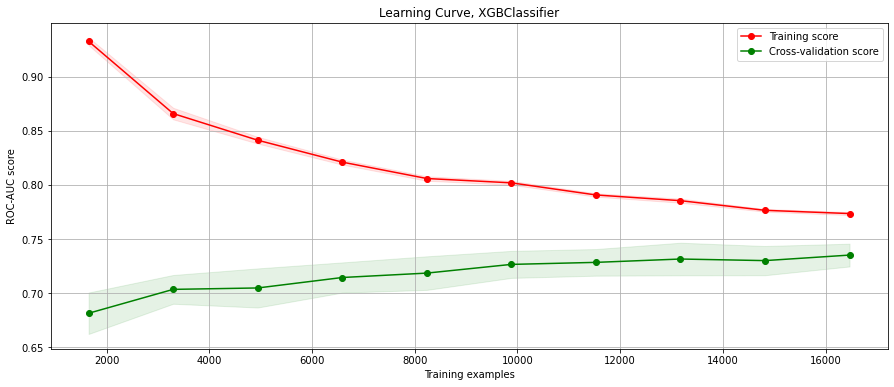

In [66]:
xgb_class = xgb.XGBClassifier(
    booster='gbtree', max_depth=2, n_estimators=100, learning_rate=0.1).fit(X_train_best, y)
plot_learning_curve(
    xgb_class, 'Learning Curve, XGBClassifier', X_train_best, y, cv=cv, train_sizes=np.linspace(.1, 1.0, 10))
plt.show()

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Более тщательно отбирать признаки, добавить новые "хорошие" признаки.